In [2]:
import sys
import pandas as pd
import numpy as np
import nltk
import re
from math import log
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from nltk.stem import SnowballStemmer


In [3]:
lowercase = None
if len(sys.argv) == 2 and sys.argv[1].upper() == 'YES':
    ignore_step = 'lowercase'
else:
    ignore_step = 'None'

In [4]:
print("Vera, Jose, A20372685 solution:")
print(f"Ignored pre-processing step: {ignore_step.upper()}")

Vera, Jose, A20372685 solution:
Ignored pre-processing step: NONE


In [5]:
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

In [6]:
fake_news['class'] = 0  
real_news['class'] = 1  

data = pd.concat([fake_news, real_news], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)  ## Shuffle
data['text'] = data['title'] + ' ' + data['text']  ## Combine title and text

In [7]:
ps = PorterStemmer() #Stemmer that will be used for stemming
stop_words = set(stopwords.words('english'))
##If argument YES given, ingore_step will be 'lowercase', and lowercasing step will be skipped.
if ignore_step != 'lowercase':
    data['text'] = data['text'].apply(lambda x: x.lower())  # Lowercase
##Remove Stopwords
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  # Remove stop words
##Perfrom Stemming
data['text'] = [' '.join([ps.stem(word) for word in x.split()]) for x in data['text']]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.2, random_state=42)

In [9]:
train_count_fake = list(y_train).count(0)
train_count_real = list(y_train).count(1)

test_count_fake = list(y_test).count(0)
test_count_real = list(y_test).count(1)

In [10]:
vectorizer = CountVectorizer(binary=True)

vectorizer.fit(X_train)

X_train_bow_matrix = vectorizer.transform(X_train).toarray()

In [11]:
def my_preprocessor(text):
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

In [12]:
def train_naive_bayes(X_train):
    ##Binary count vectorizer object
    vectorizer = CountVectorizer(binary=True)

    vectorizer.fit(X_train)

    X_train_bow_matrix = vectorizer.transform(X_train).toarray()
    ##Separate BOW into different matrices
    
    X_fake = X_train_bow_matrix[y_train == 0, :]
    X_real = X_train_bow_matrix[y_train == 1, :]

    log_prior = {}

    # Calculate P(c) term
    numb_doc = len(X_train_bow_matrix)
    numb_classes = 2
    class_counts = np.bincount(y_train)
    for label in range(numb_classes):
        log_prior[label] = np.log(class_counts[label]/numb_doc) 

    # Create Vocabulary of D
    V = vectorizer.get_feature_names_out()
    ##Get necessary counts to calcualte probability
    real_word_counts = np.sum(X_real, axis=0)
    fake_word_counts = np.sum(X_fake, axis=0)
    real_words_total = np.sum(real_word_counts)
    fake_words_total = np.sum(fake_word_counts)
    real_doc_count = len(X_real)
    fake_doc_count = len(X_fake)

    #Calculate probabilites using lapace smoothing of 1
    fake_probs = {}
    real_probs = {}
    for word in range(len(V)):
        fake_count = fake_word_counts[word]
        real_count = real_word_counts[word]
        fake_probs[V[word]] = np.log((fake_count + 1) / (fake_words_total + len(V)))
        real_probs[V[word]] = np.log((real_count + 1) / (real_words_total + len(V)))
    # Create log_likelihood dictionary
    log_likelihood = {}
    log_likelihood[0] = fake_probs
    log_likelihood[1] = real_probs

    V_list = V.tolist()
    
    return log_prior,log_likelihood,V_list,




In [13]:
def test_naive_bayes(X_test, log_prior, log_likelihood, C, V):
    
    vectorizer = CountVectorizer(vocabulary=V, binary=True)
    testdoc = vectorizer.transform(X_test).toarray()

    # Create a matrix of log likelihoods for all words in the vocabulary for each class
    log_likelihood_matrix = np.array([list(log_likelihood[c].values()) for c in C]).T

    # Calculate the sum of log likelihoods for each document and class using broadcasting
    sum_c = (testdoc @ log_likelihood_matrix) + list(log_prior.values())

    # Choose the class with the highest sum
    best_c = np.argmax(sum_c, axis=1)

    return best_c, sum_c


In [14]:
print('Training classifier…')

Training classifier…


In [15]:
log_prior, log_likelihood, V = train_naive_bayes(X_train)

: 

: 

In [ ]:
print('Testing classifier…')
y_pred, sum_c = test_naive_bayes(X_test, log_prior, log_likelihood, [0,1], V)

Testing classifier…


In [ ]:
print("Test results / metrics:\n")

Test results / metrics:



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_mat = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = conf_mat.ravel()

sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred)
npv = tn / (tn + fn)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Number of true positives:", tp)
print("Number of true negatives:", tn)
print("Number of false positives:", fp)
print("Number of false negatives:", fn)
print("Sensitivity (recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Negative predictive value:", npv)
print("Accuracy:", accuracy)
print("F-score:", f1)


Number of true positives: 4055
Number of true negatives: 4630
Number of false positives: 167
Number of false negatives: 128
Sensitivity (recall): 0.9693999521874253
Specificity: 0.9651865749426725
Precision: 0.9604452865940313
Negative predictive value: 0.973097940311055
Accuracy: 0.9671492204899778
F-score: 0.9649018441403926


In [ ]:
while True:
    sentence = input("Enter your sentence: ")
    if ignore_step != 'lowercase':
        sentence = sentence.lower()
    #Remove stop words and rejoin the remaining words back into a string
    filtered_text = ' '.join([word for word in sentence.split() if word.lower() not in stop_words]) 
    ##Perfrom Stemming
    text = [' '.join([ps.stem(word) for word in filtered_text.split()])]

    class_label, class_probabilities = test_naive_bayes(text,log_prior, log_likelihood, [0,1], V)
    if class_label[0] == 0:
        other_label = 1
        class_name = 'Fake'
        other_name = 'Real'
    else:
        other_label = 0
        class_name = 'Real'
        other_name = 'Fake'

    print(f"Sentence '{sentence}' was classified as '{class_name}'.")
    print(f"P({class_name} | S) = {class_probabilities[0][class_label[0]]:.4f}")
    print(f"P({other_name} | S) = {class_probabilities[0][other_label]:.4f}")
    
    answer = input("Do you want to enter another sentence [Y/N]? ")
    if answer.lower() != 'y':
        break


Sentence 'The president has declared a state of emergency' was classified as 'Fake'.
P(Fake | S) = -53.1760
P(Real | S) = -55.8163


In [ ]:
import matplotlib.pyplot as plt


0.9718829223323346

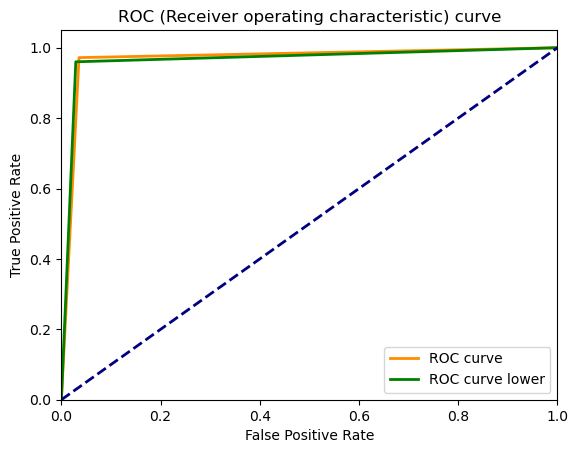

In [ ]:
plt.figure()
lw = 2
fpr = 165/(165+4476)
tpr = 4217/(4217+122)

fpr2 = 0.029
tpr2 = 0.96

plt.plot ([0, fpr,1],[0,tpr, 1],color='darkorange',lw =lw, label='ROC curve')
plt.plot ([0, fpr2,1],[0,tpr2, 1],color='green',lw =lw, label='ROC curve lower')

plt.plot ([0, 1], [0, 1], color='navy', lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.title ('ROC (Receiver operating characteristic) curve')
plt.legend (loc="lower right")
plt.show ()